# Introduction

   Customer complaints can give us valuable insights into the problems they are experiencing in the financial marketplace. By adding their voice, customers help us improve our services and help us comply with rules and regulations. The **Consumer Financial Protection Bureau (CFPB)** makes the customer complaints database available to the public. The database can be downloaded from [here](https://www.consumerfinance.gov/data-research/consumer-complaints/#download-the-data) 

   The purpose of this project is to look at customer complaints trends and investigate what topics are being discussed using topic modeling. Specifically, we will use Latent Dirichlet Allocation (LDA) which is a widely used topic modelling technique. This project is broken up into 2 parts. Part 1 focuses on EDA and visualization of the data, and Part 2 goes into LDA Topic Modeling using the Gensim library. 


# Loading the Data

In [21]:
import warnings #remove all warnings
warnings.filterwarnings('ignore')
import pandas as pd
df = pd.read_csv('complaints.csv')
df.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-05-03,Student loan,Private student loan,Struggling to repay your loan,Can't get other flexible options for repaying ...,NaN,NaN,Ameritech Financial,FL,33023,NaN,Consent not provided,Web,2019-05-15,Untimely response,No,NaN,3231257
1,2022-03-14,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,NaN,"EQUIFAX, INC.",PA,19132,NaN,NaN,Web,2022-03-14,In progress,Yes,NaN,5314604
2,2022-03-01,Debt collection,Medical debt,Written notification about debt,Didn't receive enough information to verify debt,NaN,NaN,The Law Offices of Mitchell D. Bluhm & Associates,FL,32825,NaN,NaN,Web,2022-03-01,Closed with non-monetary relief,Yes,NaN,5271887


In [22]:
df.shape

(2536961, 18)

# Data Cleaning

At this stage, we are only interested in 3 columns: **'Product', 'Consumer complaint narrative'** and **'State'**. The 'Product' and 'State' variables can help us identify trends such as the product type and location with the most volume of complaints. We also want to remove rows where the narrative is blank. Finally, we will also add a column encoding the product as an integer because categorical variables are often better represented by integers than strings. The encoding can help us build predictive models for further research. After cleaning up this is what our dataset looks like.

In [23]:
from io import StringIO
col = ['Product', 'Consumer complaint narrative', 'State']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Consumer_complaint_narrative','State']
df

,Product,Consumer_complaint_narrative,State
5,"Credit reporting, credit repair services, or o...",First Progress Card was notified throughout th...,DE
12,"Credit reporting, credit repair services, or o...","As by Law, under 15 U.S Code 1601- Congression...",MD
24,"Credit reporting, credit repair services, or o...",This is a copy of my most recent email to XXXX...,LA
25,"Credit reporting, credit repair services, or o...",Comment TransUnion Continues to report XXXX Ac...,CA
26,Credit card or prepaid card,This is in reference to case number XXXX. This...,CA
...,...,...,...
2536955,Credit card,"Automated calls from "" XXXX with Capital One '...",TX
2536956,Debt collection,I have disputed my debts several times with no...,UT
2536957,Mortgage,My father died in XX/XX/XXXX. Left me his only...,OK
2536958,Credit reporting,cfbp i would Like to file a complaint on Exper...,MN


After removing rows with blank narratives, we end up with just under 1 million records

In [24]:
df.shape

(887750, 3)

In [25]:
#Get complaint count by product type
df.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    360180
Debt collection                                                                 169758
Mortgage                                                                         89176
Credit card or prepaid card                                                      67404
Checking or savings account                                                      42233
Credit reporting                                                                 31588
Student loan                                                                     29977
Money transfer, virtual currency, or money service                               21146
Credit card                                                                      18838
Vehicle loan or lease                                                            16704
Bank account or service                                                          14885
Payday loan, title loan, or personal loan  

Looking at the data above, it looks like we can clean our data further by consolidating the products as follows:

- Consolidate “Credit reporting” into “Credit reporting, credit repair services, or other personal consumer reports”.
- Consolidate “Credit card” into “Credit card or prepaid card”.
- Consolidate “Payday loan” into “Payday loan, title loan, or personal loan”.
- Consolidate “Virtual currency” into “Money transfer, virtual currency, or money service”.
- “Other financial service” has very few number of complaints and it does not mean anything, so, I decide to remove it.

In [26]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df.loc[df['Product'] == 'Prepaid card', 'Product'] = 'Credit card or prepaid card'
df = df[df.Product != 'Other financial service']

We were able to consolidate the Products into 12 different labels

In [27]:
df.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    391768
Debt collection                                                                 169758
Mortgage                                                                         89176
Credit card or prepaid card                                                      87692
Checking or savings account                                                      42233
Student loan                                                                     29977
Money transfer, virtual currency, or money service                               21162
Vehicle loan or lease                                                            16704
Bank account or service                                                          14885
Payday loan, title loan, or personal loan                                        13136
Consumer Loan                                                                     9470
Money transfers                            

# Text Preprocessing to Prepare for LDA Analysis

To prepare our dataset for analysis, let’s work to transform the textual data in a format that will serve as an 
input for training our LDA model. We start by cleaning the text and by converting to lower case and removing speacial characters. Next, start removing stopwords. Stopwords are words that do not contribute to the importance in a sentence such as 'a', 'the', 'is', 'I' etc. Finally we perform stemming to change words into their root form.

In [28]:
# Load regular expression library
import re
#Convert to lower case

df['Consumer_complaint_narrative'] = df['Consumer_complaint_narrative'].str.lower()

#Remove special characters
df['Consumer_complaint_narrative'] = df['Consumer_complaint_narrative'].str.replace(r"[^a-zA-Z ]+", "")

#Remove stopwords
from nltk.corpus import stopwords
new_stopwords = ["xx", "xxx", "xxxx", "xxxxx", "xxxxxx", "xxxxxxx","xxxxxxxx","xxxxxxxxx","xxxxxxxxxx"]
stop = stopwords.words('english')
stop.extend(new_stopwords)

df['Consumer_complaint_narrative'] = df['Consumer_complaint_narrative'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop)]))

#Stemming
from nltk.stem import PorterStemmer, WordNetLemmatizer
porter_stemmer = PorterStemmer()
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

df['Consumer_complaint_narrative']=df['Consumer_complaint_narrative'].apply(stem_sentences)
df

,Product,Consumer_complaint_narrative,State
5,"Credit reporting, credit repair services, or o...",first progress card notifi throughout year reg...,DE
12,"Credit reporting, credit repair services, or o...",law us code congression find declar purpos inf...,MD
24,"Credit reporting, credit repair services, or o...",copi recent email tri year get free credit rep...,LA
25,"Credit reporting, credit repair services, or o...",comment transunion continu report account numb...,CA
26,Credit card or prepaid card,refer case number case summarili close duplic ...,CA
...,...,...,...
2536955,Credit card or prepaid card,autom call capit one call home phone excess ti...,TX
2536956,Debt collection,disput debt sever time resolut submit paperwor...,UT
2536957,Mortgage,father die left son belong also singl mother e...,OK
2536958,"Credit reporting, credit repair services, or o...",cfbp would like file complaint experian report...,MN


# Exploratory Analysis

Lets do some visualization using the Seaborn package to create a bar chart to show the volume of complaint by 
product type. As you can see from out plot below, we have an imbalanced dataset biased towards **'Credit reporting, credit repair services,or other personal consumer reports', 'Debt Collection'** and **'Mortgage'**. When this occurs we can try to balance our dataset, for example by undersampling or oversampling each class. However, in our case, we are just doing topic modeling and the majority classes might be of great interest. Therefore, we will leave it as is.

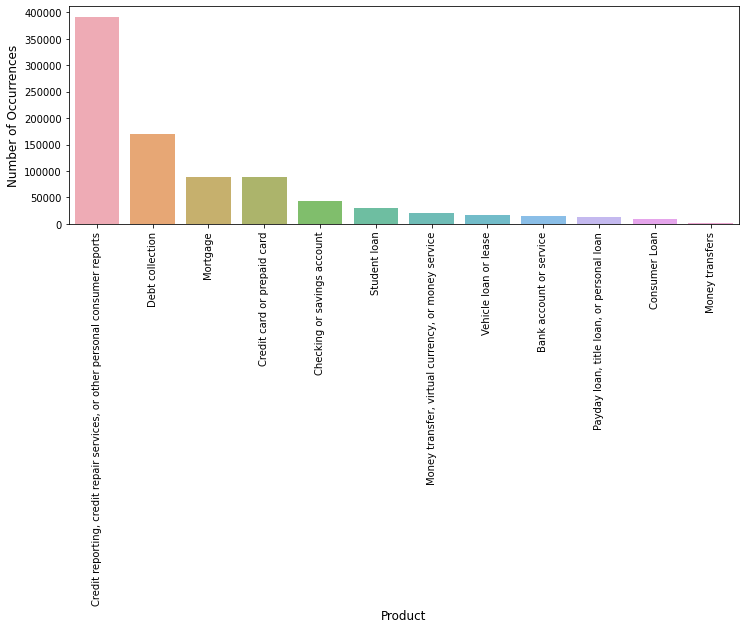

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
cnt_pro = df['Product'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

## Where are the complaints coming from?

In [30]:
state = df.State.value_counts().rename_axis('State').reset_index(name='Complaint_Count')
state


,State,Complaint_Count
0,CA,115212
1,FL,93998
2,TX,84006
3,GA,56467
4,NY,52589
...,...,...
58,AA,24
59,MP,11
60,AS,8
61,MH,4


We can create a Choropleth maps to visualize the volume of complaints by state. It looks like most of the complaints come from the more populous state such as California, Texas and Florida

In [31]:

#import libraries
import pandas as pd
import plotly.express as px
  
# create choropleth map for the data
# color will be the column to be color-coded
# locations is the column with sppatial coordinates
fig = px.choropleth(state, locations='State',
                    locationmode="USA-states", color='Complaint_Count', scope="usa")
 
fig.show()

## Word Cloud

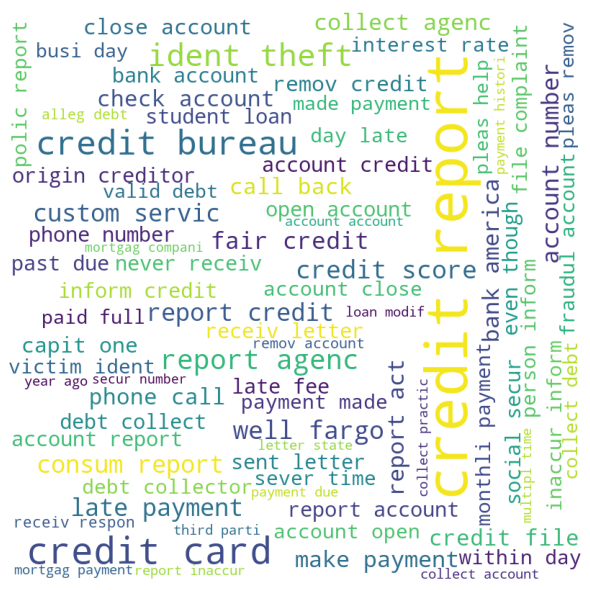

In [32]:
# import wordcloud modules
from wordcloud import WordCloud

# Join the diffferent narratives together

long_string = ','.join(list(df['Consumer_complaint_narrative'].values))

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', max_words = 80, min_font_size = 10).generate(long_string)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Tokenization

To begin the LDA analysis we first tokenize the sentences to split the sentences into words using gensim’s simple_preprocess().

In [33]:
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) #removes punctuations.
        yield(sent)  

# Convert to list
data = df.Consumer_complaint_narrative.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['first', 'progress', 'card', 'notifi', 'throughout', 'year', 'regard', 'inaccur', 'report', 'bureau', 'consum', 'suffer', 'protect', 'care', 'act', 'publ', 'first', 'progress', 'card', 'suppos', 'respons', 'investig', 'take', 'proper', 'action', 'determin', 'made', 'good', 'faith', 'effort', 'investig', 'disput', 'wherea', 'compani', 'consum', 'account', 'report', 'day', 'late', 'payment', 'made', 'arrang', 'request', 'due', 'first', 'progress', 'card', 'report', 'account', 'day', 'late', 'day', 'late', 'reflect', 'current', 'discrep', 'continu', 'reflect', 'day', 'late', 'day', 'late', 'current', 'back', 'day', 'late', 'day', 'late', 'final', 'notic', 'discrep', 'lack', 'support', 'good', 'faith', 'report', 'first', 'progress', 'card', 'notifi', 'regard', 'suffer', 'person', 'attempt', 'recov', 'wherea', 'correspond', 'state', 'send', 'letter', 'via', 'fax', 'explain', 'provid', 'account', 'ident', 'inform', 'request', 'regard', 'account', 'await', 'relief', 'good', 'letter', 'neg',